# Testing Coherent Dedispersion

We need a nice way of testing coherent dedispersion that does not involve simply dedispersing real pulsar data and eyeballing it. Here, I use a sum of a few manually-placed wavelets and try dedispersing them.

In [1]:
%matplotlib inline

import ipywidgets as widgets
import numpy as np
import astropy.units as u
from astropy.time import Time
import pulsarbat as pb
import scipy.signal

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

## Gabor wavelet

A [Gabor wavelet](https://en.wikipedia.org/wiki/Gabor_wavelet) is a Gaussian envelope modulated by a complex exponential,

$$z(t) = \exp{\left[2 \pi i t f_0-\left(\frac{t - t_0}{\sigma_t}\right)^2\right]}$$

A Gabor wavelet is the function that minimizes the product of its standard deviations in the time and frequency domain. So in the time-frequency representation, this should show up as a small Gaussian blob localized in both time and frequency.

*Note: Apparently, this is also called a [Morlet wavelet](https://en.wikipedia.org/wiki/Morlet_wavelet). These doesn't seem to be a real difference between them. ([More info in this dsp.SE answer](https://dsp.stackexchange.com/a/2118/17721))*

In [2]:
def gabor_wavelet(t, t0, f0, ts):
    """Morlet wavelet at frequency f0 and time t0, with envelope width ts."""
    a = 2j*np.pi*(t - t0)*f0 - ((t - t0)/ts)**2
    return np.exp(a.to_value(u.one))

As an example, I generate the sum of two Morlet wavelets at $t_0 = 0$ and $f_0 = \pm 2 \, \mathrm{Hz}$ (to make the signal real-valued for easy plotting).

In [3]:
N = 2**14
SR = 128 * u.Hz
t = ((np.arange(N) - N//2)/SR).to(u.s)

z = np.zeros(N, dtype=np.complex128)
z += gabor_wavelet(t, 0 * u.s, 2 * u.Hz, ts=0.8*u.s)
z += gabor_wavelet(t, 0 * u.s, -2 * u.Hz, ts=0.8*u.s)

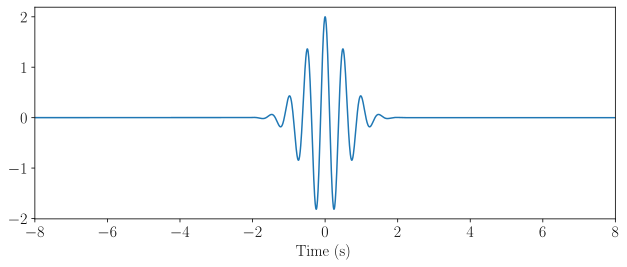

In [4]:
plt.close(0)
fig = plt.figure(0, figsize=(9, 4), tight_layout=True)
ax = fig.subplots(1, 1)
ax.plot(t.to_value(u.s), z.real)
ax.set_xlabel(r"Time (s)")
ax.set_xlim(-8, 8)
plt.show()

I use a [Short-time Fourier Transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to generate a time-frequency represention (AKA waterfall/spectrogram). (Guidelines plotted to show how the blobs are aligned).

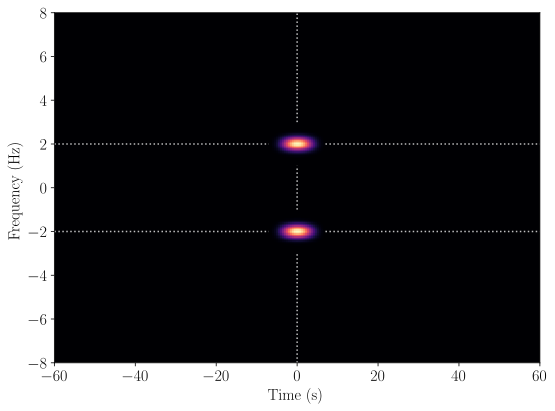

In [5]:
fs = SR.to_value(u.Hz)
ff, tt, zz = scipy.signal.stft(z, fs=fs, window='hann', nperseg=2048, noverlap=2048-64, return_onesided=False)
zz = np.fft.fftshift(zz, axes=(0,))
ff = np.fft.fftshift(ff)

tt = tt - tt[len(tt)//2]
extent = (tt[0], tt[-1], ff[0], ff[-1])

plt.close(0)
fig = plt.figure(0, figsize=(8, 6), tight_layout=True)
ax = fig.subplots(1, 1)
ax.imshow(np.abs(zz)**2, extent=extent, origin='lower', aspect='auto', cmap='magma', interpolation='nearest')
ax.set_xlabel(r"Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.vlines(x=[0, 0, 0], ymin=[-8, -1, 3], ymax=[-3, 1, 8], color='w', ls=':', alpha=0.75)
ax.hlines(y=[2, 2, -2, -2], xmin=[-60, 7, -60, 7], xmax=[-7, 60, -7, 60], color='w', ls=':', alpha=0.75)
ax.set_xlim(-60, 60)
ax.set_ylim(-8, 8)
plt.show()

As expected, we see two "Gaussian blobs" at $t = 0$ and $f = \pm 2 \, \mathrm{Hz}$.

In [6]:
 def get_stft(z, SR, nperseg=256, noverlap=None):
    fs = SR.to_value(u.MHz)
    ff, tt, zz = scipy.signal.stft(z, fs=fs, nperseg=nperseg, noverlap=None,
                                   return_onesided=False)
    zz = np.fft.fftshift(zz, axes=(0,))
    t0 = tt[0] - (tt[1] - tt[0])/2
    t1 = tt[-1] + (tt[1] - tt[0])/2

    extent = (t0, t1, (-fs - 1/fs)/2, (fs - 1/fs)/2)
    return zz, {'extent': extent, 'origin': 'lower'}

### Generating a dispersed set of Wavelets

One way to test coherent dedispersion would be to generate a signal as a sum of Morlet wavelets at different frequencies that are placed at the precise time delays to mimic interstellar dispersion.

Here I generate a $400\,\mathrm{MHz}$ signal centered at $600\,\mathrm{MHz}$. Then, I add 7 Morlet wavelets at equally spaced intervals in frequency at time offsets predicted by a dispersion measure of $10^{-2}\,\mathrm{pc}/\mathrm{cm^3}$. The wavelet at the center frequency is placed at $1000\,\mathrm{\mu s}$. Upon correct dedispersion, we would expect all the wavelets to be shifted to this particular time offset.

In [7]:
ref_freq = 600 * u.MHz
SR = 400 * u.MHz
DM = pb.DispersionMeasure(0.01)

N = 2**20
t = np.arange(N)/SR
t0 = t[400000]

x = np.zeros(N, dtype=np.complex128)
for df in np.linspace(-3*SR/8, 3*SR/8, 7):
    dt = DM.time_delay(ref_freq + df, ref_freq)
    x += gabor_wavelet(t, t0 + dt, df, 256/SR)

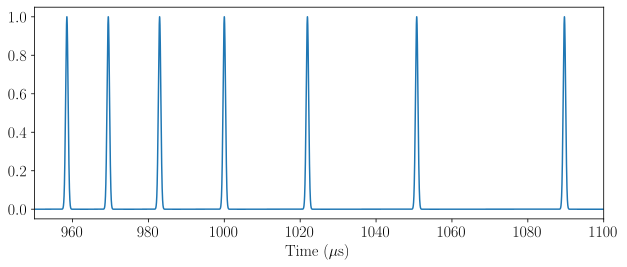

In [8]:
plt.close(0)
fig = plt.figure(0, figsize=(9, 4), tight_layout=True)
ax = fig.subplots(1, 1)
ax.plot(t.to_value(u.us), np.abs(x)**2)
ax.set_xlabel(r"Time ($\mathrm{\mu}$s)")
ax.set_xlim(950, 1100)
plt.show()

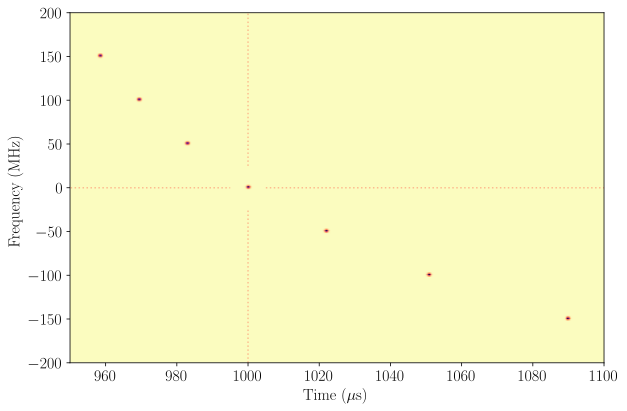

In [9]:
xx, imshow_kw = get_stft(x, SR, nperseg=256)

plt.close(0)
fig = plt.figure(0, figsize=(9, 6), tight_layout=True)
ax = fig.subplots(1, 1)
ax.imshow(np.abs(xx)**2, **imshow_kw, aspect='auto', cmap='magma_r')
ax.set_xlabel(r"Time ($\mathrm{\mu}$s)")
ax.set_ylabel("Frequency (MHz)")
ax.vlines(x=[1000, 1000], ymin=[-200, 25], ymax=[-25, 200], color='r', ls=':', alpha=0.25)
ax.hlines(y=[0, 0], xmin=[900, 1005], xmax=[995, 1200], color='r', ls=':', alpha=0.25)
ax.set_xlim(950, 1100)
ax.set_ylim(-200, 200)
plt.show()

## Coherent Dedispersion

My coherent dedispersion implementation is standard. Simply muliplying the Fourier transform of our signal with the dedispersion chirp function,

$$H(f) = \exp{\left[-\mathrm{DM} \, \mathcal{D} \, 2 \pi i f \left(\frac{1}{f_0} - \frac{1}{f}\right)^2\right]}$$

where $1/\mathcal{D} = 2.41 \times 10^{-4} \, \mathrm{MHz}^{-2} \, \mathrm{pc} \, \mathrm{cm}^{-3} \, \mathrm{s}^{-1}$ and $f_0$ is the reference frequency, usually the center frequency of the signal.

Now, we can dedisperse!

In [10]:
signal_x = pb.BasebandSignal(x.reshape(-1, 1), sample_rate=SR, center_freq=ref_freq,
                             start_time=Time(56000., format='mjd'))
signal_y = pb.coherent_dedispersion(signal_x, DM)

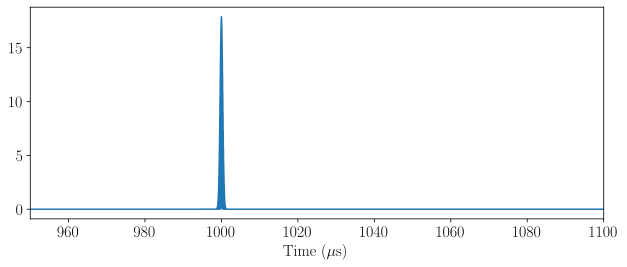

In [11]:
y = signal_y.data.squeeze()

toffset = signal_y.start_time - signal_x.start_time
noffset = int(np.rint((toffset * signal_y.sample_rate).to(u.one)))

plt.close(0)
fig = plt.figure(0, figsize=(9, 4), tight_layout=True)
ax = fig.subplots(1, 1)
ax.plot(t[noffset:].to_value(u.us)[:len(y)], np.abs(y)**2)
ax.set_xlabel(r"Time ($\mathrm{\mu}$s)")
ax.set_xlim(950,1100)
plt.show()

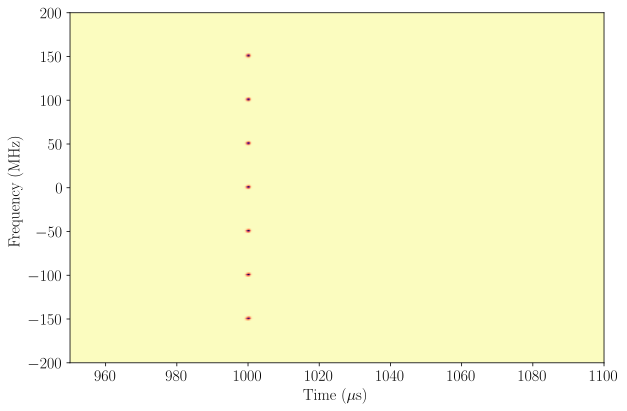

In [12]:
yy, imshow_kw = get_stft(y[:472*2048], SR, nperseg=256)

t_off = toffset.to_value(u.us)
ex = imshow_kw['extent']
imshow_kw['extent'] = (ex[0] + t_off, ex[1] + t_off, ex[2], ex[3])

plt.close(0)
fig = plt.figure(0, figsize=(9, 6), tight_layout=True)
ax = fig.subplots(1, 1)
ax.imshow(np.abs(yy)**2, **imshow_kw, aspect='auto', cmap='magma_r')
ax.set_xlabel(r"Time ($\mathrm{\mu}$s)")
ax.set_ylabel("Frequency (MHz)")
ax.set_xlim(950, 1100)
ax.set_ylim(-200, 200)
plt.show()

If we zoom in, we see that the blobs have not experienced any additional smearing or distortion - which is good!

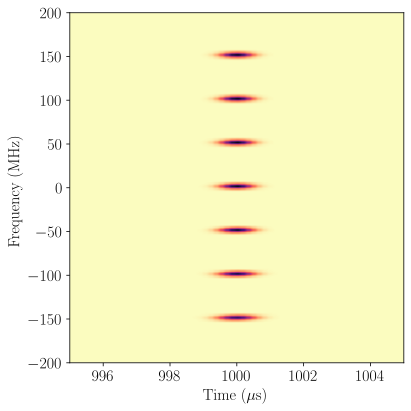

In [13]:
yy, imshow_kw = get_stft(y[:472*2048], SR, nperseg=128, noverlap=127)

t_off = toffset.to_value(u.us)
ex = imshow_kw['extent']
imshow_kw['extent'] = (ex[0] + t_off, ex[1] + t_off, ex[2], ex[3])

plt.close(0)
fig = plt.figure(0, figsize=(6, 6), tight_layout=True)
ax = fig.subplots(1, 1)
ax.imshow(np.abs(yy)**2, **imshow_kw, aspect='auto', cmap='magma_r')
ax.set_xlabel(r"Time ($\mathrm{\mu}$s)")
ax.set_ylabel("Frequency (MHz)")
ax.set_xlim(995, 1005)
ax.set_ylim(-200, 200)
plt.show()

### Reversing dedispersion

Now, I try reversing this operation by dedispersing by the negative of the DM and see how it compares with the original function!

In [14]:
signal_z = pb.coherent_dedispersion(signal_y, -DM)

Plotting the signal and spectrogram in this case is meaningless as ideally, it would look identical to the previous plot. So, here are the residuals instead.

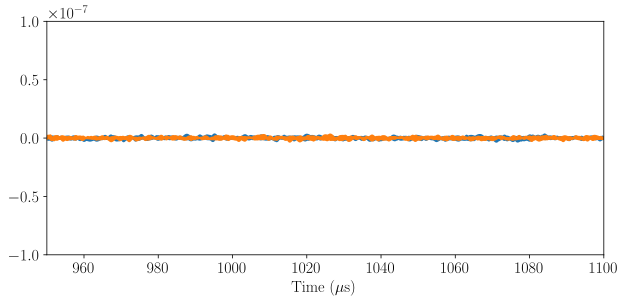

In [15]:
z = signal_z.data.squeeze()

toffset2 = signal_z.start_time - signal_x.start_time
noffset2 = int(np.rint((toffset2 * signal_z.sample_rate).to(u.one)))

t2 = t[noffset2:][:436*2048]
x2 = x[noffset2:][:436*2048]
z2 = z[:436*2048]

plt.close(0)
fig = plt.figure(0, figsize=(9, 4.5), tight_layout=True)
ax = fig.subplots(1, 1)
ax.plot(t2, (z2 - x2).real, '-', t2, (z2 - x2).imag, '-')
ax.set_xlabel(r"Time ($\mathrm{\mu}$s)")
ax.set_xlim(950,1100)
ax.set_ylim(-1E-7, 1E-7)
plt.show()

The residuals are insignificant (of order $< 10^{-8}$). Coherent dedispersion passes the reversibility test! Any signal should ideally pass this test as long as there isn't any power too close to the Nyquist frequency. Any sufficiently low-pass-filtered signal should be good for testing coherent dedispersion reversibility.